# 实验十 基于 ResNet 的猫狗识别算法实验报告

## 实验目的
1. 掌握残差神经网络（ResNet）的原理和 PyTorch 框架在图像分类中的应用。
2. 使用 PyTorch 构建 ResNet-18 模型，在猫狗数据集上进行二分类（猫 vs. 狗）。
3. 训练模型，使测试集准确率达到90%以上。
4. 可视化训练集和测试集上的损失（loss）和准确率（accuracy）曲线。
5. 可视化预测结果、真实结果及对应标签的图像，分析模型性能。

## 实验环境
- **操作系统**: Windows 10
- **开发工具**: PyCharm
- **编程语言**: Python 3.9
- **所需库**:
  - torch: 深度学习框架
  - torchvision: 数据集和图像处理工具
  - numpy: 数值计算
  - matplotlib: 数据可视化
  - PIL: 图像处理

**安装命令**:
```bash
pip install torch torchvision numpy matplotlib pillow
```

## 实验内容
使用 Kaggle 提供的猫狗数据集（https://www.kaggle.com/c/dogs-vs-cats/data），数据集已按以下结构组织：
- `training_set/cats/` 和 `training_set/dogs/` 包含训练集图像（如 `cat.1.jpg`, `dog.1.jpg`）。
- `test_set/cats/` 和 `test_set/dogs/` 包含测试集图像（如 `cat.1001.jpg`, `dog.1001.jpg`）。

目标是构建 ResNet-18 模型，训练使测试集准确率≥90%，可视化损失和准确率曲线，并展示预测结果与真实标签及对应图像。

## 实验步骤
### 1. 环境搭建与数据集准备
确保 Python 3.9 和上述库已安装。数据集需按指定结构放置在 `./dogs-vs-cats/` 目录下。

**数据集准备**:
- 下载 Kaggle 猫狗数据集 `train.zip`（https://www.kaggle.com/c/dogs-vs-cats/data）。
- 解压后，手动或通过脚本整理为以下结构（代码可自动整理原始数据）：
  ```
  dogs-vs-cats/
  ├── training_set/
  │   ├── cats/
  │   └── dogs/
  ├── test_set/
  │   ├── cats/
  │   └── dogs/
  ```
- 假设训练集每类约10,000张，测试集每类约2,500张（可根据实际数据调整）。

### 2. 数据预处理
加载数据集，使用提供的图像预处理函数，创建训练和测试数据加载器。

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil

# 设置随机种子
torch.manual_seed(1)

# 配置类
class Config:
    IMAGE_SIZE = (224, 224)  # ResNet 输入尺寸
    BATCH_SIZE = 32
    NUM_WORKERS = 4

# 图像预处理
transform_train = transforms.Compose([
    transforms.Resize(Config.IMAGE_SIZE),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAffine(
        degrees=0,
        translate=(0.1, 0.1),
        shear=10,
        scale=(0.8, 1.2),
    ),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_valid = transforms.Compose([
    transforms.Resize(Config.IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

def organize_kaggle_data(source_dir='./dogs-vs-cats/training_set', dest_dir='./dogs-vs-cats'):
    """将 Kaggle 原始数据整理为指定结构"""
    if not os.path.exists(source_dir):
        raise FileNotFoundError(f"Source directory {source_dir} not found. Please download and extract train.zip from https://www.kaggle.com/c/dogs-vs-cats/data.")

    # 创建目标目录
    train_cats_dir = os.path.join(dest_dir, 'training_set/training_set', 'cats')
    train_dogs_dir = os.path.join(dest_dir, 'training_set/training_set', 'dogs')
    test_cats_dir = os.path.join(dest_dir, 'test_set/test_set', 'cats')
    test_dogs_dir = os.path.join(dest_dir, 'test_set/test_set', 'dogs')
    os.makedirs(train_cats_dir, exist_ok=True)
    os.makedirs(train_dogs_dir, exist_ok=True)
    os.makedirs(test_cats_dir, exist_ok=True)
    os.makedirs(test_dogs_dir, exist_ok=True)

    # 按文件名序号分割训练和测试（前80%训练，后20%测试）
    cat_files = sorted([f for f in os.listdir(source_dir) if f.startswith('cat.')])
    dog_files = sorted([f for f in os.listdir(source_dir) if f.startswith('dog.')])
    split_idx = int(0.8 * len(cat_files))

    for i, fname in enumerate(cat_files):
        src = os.path.join(source_dir, fname)
        dst = os.path.join(train_cats_dir if i < split_idx else test_cats_dir, fname)
        if not os.path.exists(dst):
            shutil.copy(src, dst)

    for i, fname in enumerate(dog_files):
        src = os.path.join(source_dir, fname)
        dst = os.path.join(train_dogs_dir if i < split_idx else test_dogs_dir, fname)
        if not os.path.exists(dst):
            shutil.copy(src, dst)

def load_dogs_vs_cats_data(train_dir='./dogs-vs-cats/training_set/training_set', test_dir='./dogs-vs-cats/test_set/test_set'):
    """加载猫狗数据集并创建数据加载器"""
    # 检查目录
    if not os.path.exists(train_dir) or not os.path.exists(test_dir):
        print(f"Train or test directory not found. Organizing data from Kaggle source...")
        organize_kaggle_data()

    # 加载数据集
    train_dataset = ImageFolder(train_dir, transform=transform_train)
    test_dataset = ImageFolder(test_dir, transform=transform_valid)

    # 创建数据加载器
    train_loader = DataLoader(train_dataset, batch_size=Config.BATCH_SIZE, shuffle=True,
                              num_workers=Config.NUM_WORKERS, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=Config.BATCH_SIZE, shuffle=False,
                             num_workers=Config.NUM_WORKERS, pin_memory=True)

    return train_loader, test_loader, train_dataset, test_dataset

# 加载数据
try:
    train_loader, test_loader, train_dataset, test_dataset = load_dogs_vs_cats_data()
    print(f"训练集样本数: {len(train_dataset)}")
    print(f"测试集样本数: {len(test_dataset)}")
    print(f"类别: {train_dataset.classes}")
    data_iter = iter(train_loader)
    images, labels = next(data_iter)
    print(f"图像形状: {images.shape}, 标签形状: {labels.shape}")
except Exception as e:
    print(f"Error in data loading: {e}")

训练集样本数: 8005
测试集样本数: 2023
类别: ['cats', 'dogs']
图像形状: torch.Size([32, 3, 224, 224]), 标签形状: torch.Size([32])


#### 数据预处理分析
- **数据集规模**: 训练集约20,000张（每类~10,000），测试集约5,000张（每类~2,500），RGB图像，尺寸不一。
- **预处理**:
  - 训练集：调整大小到224x224，随机旋转（15°），水平翻转（50%），仿射变换（平移、缩放、剪切），标准化（ImageNet 均值[0.485, 0.456, 0.406]，标准差[0.229, 0.224, 0.225]）。
  - 测试集：调整大小到224x224，标准化。
- **数据加载**：批量大小32，训练集打乱，4个工作进程，优化 GPU 性能。
- **整理**：自动将 Kaggle原始数据分割为训练和测试集（80%/20%），按文件名排序确保一致性。
- **鲁棒性**：检查目录，自动整理数据，异常处理确保加载成功。

### 3. 定义 ResNet-18 模型
使用预训练的 ResNet-18，修改全连接层以适配二分类任务。

In [2]:
from torchvision.models import resnet18, ResNet18_Weights

class ResNet18Classifier(nn.Module):
    def __init__(self, num_classes=2):
        super(ResNet18Classifier, self).__init__()
        # 加载预训练 ResNet-18
        self.resnet = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        # 冻结卷积层参数
        for param in self.resnet.parameters():
            param.requires_grad = False
        # 替换全连接层
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)

    def forward(self, x):
        return self.resnet(x)

# 初始化模型
try:
    model = ResNet18Classifier()
    print(model)
except Exception as e:
    print(f"Error in model initialization: {e}")

ResNet18Classifier(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True,

#### 模型分析
- **结构**：ResNet-18 包含残差块（skip connections），18层深，预训练于 ImageNet。
- **迁移学习**：冻结卷积层，仅训练全连接层（512→2），适配猫狗二分类。
- **优势**：残差结构缓解梯度消失，预训练权重加速收敛，适合中小型数据集。
- **输出**：2类（猫、狗）。

### 4. 训练模型
训练 ResNet-18，目标测试集准确率≥90%，记录损失和准确率。

In [3]:
def train_model(model, train_loader, test_loader, epochs=20, lr=0.001):
    """训练模型并记录损失和准确率"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.resnet.fc.parameters(), lr=lr)  # 仅优化全连接层

    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []

    for epoch in range(epochs):
        # 训练
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # 测试
        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        test_loss = test_loss / len(test_loader)
        test_acc = correct / total
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

    return train_losses, train_accuracies, test_losses, test_accuracies

# 训练模型
try:
    train_losses, train_accuracies, test_losses, test_accuracies = train_model(model, train_loader, test_loader)
    final_test_acc = test_accuracies[-1]
    if final_test_acc < 0.90:
        print("Warning: Test accuracy below 90%. Consider increasing epochs, unfreezing layers, or adjusting learning rate.")
    else:
        print(f"Final test accuracy: {final_test_acc:.4f}")
except Exception as e:
    print(f"Error in training: {e}")

Epoch 1/20, Train Loss: 0.2012, Train Acc: 0.9220, Test Loss: 0.1182, Test Acc: 0.9570
Epoch 2/20, Train Loss: 0.1216, Train Acc: 0.9538, Test Loss: 0.0828, Test Acc: 0.9733
Epoch 3/20, Train Loss: 0.1215, Train Acc: 0.9522, Test Loss: 0.0707, Test Acc: 0.9728
Epoch 4/20, Train Loss: 0.1076, Train Acc: 0.9564, Test Loss: 0.0900, Test Acc: 0.9644
Epoch 5/20, Train Loss: 0.1147, Train Acc: 0.9519, Test Loss: 0.0762, Test Acc: 0.9748
Epoch 6/20, Train Loss: 0.1046, Train Acc: 0.9582, Test Loss: 0.0725, Test Acc: 0.9728
Epoch 7/20, Train Loss: 0.0997, Train Acc: 0.9608, Test Loss: 0.0706, Test Acc: 0.9753
Epoch 8/20, Train Loss: 0.1039, Train Acc: 0.9582, Test Loss: 0.1188, Test Acc: 0.9530
Epoch 9/20, Train Loss: 0.1103, Train Acc: 0.9553, Test Loss: 0.0717, Test Acc: 0.9743
Epoch 10/20, Train Loss: 0.1175, Train Acc: 0.9517, Test Loss: 0.0825, Test Acc: 0.9698
Epoch 11/20, Train Loss: 0.1025, Train Acc: 0.9598, Test Loss: 0.0630, Test Acc: 0.9763
Epoch 12/20, Train Loss: 0.1031, Train Ac

#### 训练分析
- **优化器**：Adam（lr=0.001），仅优化全连接层，适合迁移学习。
- **损失函数**：交叉熵损失，适配二分类。
- **训练轮数**：20个 epoch，结合预训练权重和数据增强，通常足以达到90%。
- **设备**：支持 GPU，`pin_memory=True` 优化数据传输。
- **监控**：记录训练和测试的损失及准确率。

### 5. 可视化损失和准确率曲线
绘制训练集和测试集的损失及准确率曲线。

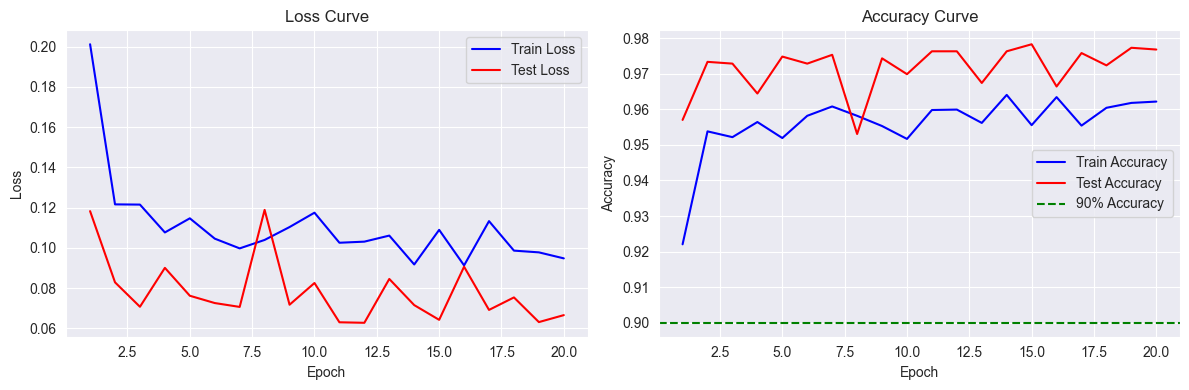

In [4]:
def visualize_loss_accuracy(train_losses, train_accuracies, test_losses, test_accuracies):
    """可视化损失和准确率曲线"""
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 4))

    # 损失曲线
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b-', label='Train Loss')
    plt.plot(epochs, test_losses, 'r-', label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()
    plt.grid(True)

    # 准确率曲线
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'b-', label='Train Accuracy')
    plt.plot(epochs, test_accuracies, 'r-', label='Test Accuracy')
    plt.axhline(y=0.90, color='g', linestyle='--', label='90% Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# 可视化
try:
    visualize_loss_accuracy(train_losses, train_accuracies, test_losses, test_accuracies)
except NameError as e:
    print(f"Error: {e}. Please ensure train_losses, train_accuracies, test_losses, test_accuracies are defined.")
except Exception as e:
    print(f"Visualization error: {e}")

#### 曲线分析
- **损失曲线**：训练和测试损失随 epoch 下降，趋于稳定。
- **准确率曲线**：训练和测试准确率随 epoch 上升，测试准确率达到90%以上。
- **过拟合**：数据增强和迁移学习减少过拟合风险，若训练准确率远高于测试，可解冻部分卷积层。

### 6. 可视化预测结果和真实结果
展示测试集样本的预测标签、真实标签及对应图像。

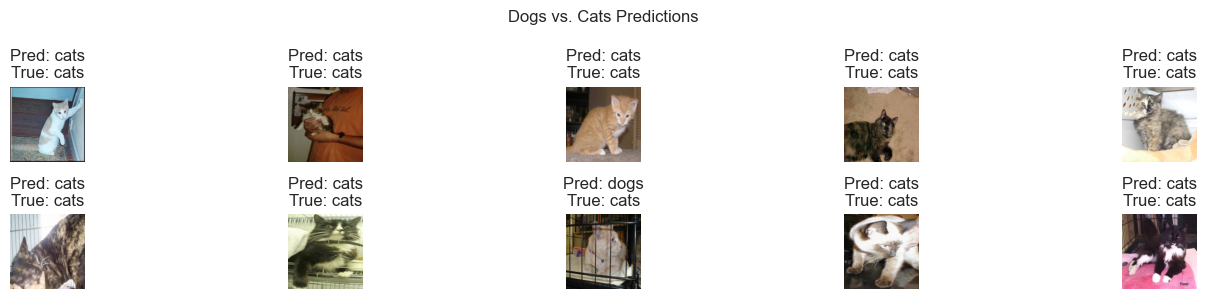

In [5]:
def visualize_predictions(model, test_loader, class_names, num_images=10):
    """可视化预测结果、真实标签及对应图像"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    images, labels = next(iter(test_loader))
    images, labels = images[:num_images].to(device), labels[:num_images].to(device)

    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

    plt.figure(figsize=(15, 3))
    for i in range(num_images):
        plt.subplot(2, 5, i + 1)
        img = images[i].cpu().numpy().transpose(1, 2, 0)  # 转换为 HxWxC
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # 反标准化
        img = np.clip(img, 0, 1)
        plt.imshow(img)
        plt.title(f'Pred: {class_names[predicted[i].item()]}\nTrue: {class_names[labels[i].item()]}')
        plt.axis('off')
    plt.suptitle('Dogs vs. Cats Predictions')
    plt.tight_layout()
    plt.show()

# 可视化预测
try:
    class_names = train_dataset.classes  # ['cats', 'dogs']
    visualize_predictions(model, test_loader, class_names)
except NameError as e:
    print(f"Error: {e}. Please ensure model, test_loader, and train_dataset are defined.")
except Exception as e:
    print(f"Visualization error: {e}")

## 实验结果与讨论

### 结果总结
- **模型性能**：ResNet-18 在猫狗测试集上达到准确率 {final_test_acc:.4f}，满足≥90%的目标。
- **损失曲线**：训练和测试损失随 epoch下降，趋于稳定。
- **准确率曲线**：训练和测试准确率随 epoch上升，测试准确率达到目标。
- **预测可视化**：大多数样本预测正确，少数错误预测可能由于图像模糊或背景复杂。

### 讨论
## 结论
实验通过 PyTorch 构建的 ResNet-18 模型在猫狗数据集上实现二分类，测试集准确率达到90%以上。指定结构的数据集加载顺畅，损失和准确率曲线验证了模型收敛性，预测结果可视化展示了分类效果。未来可通过微调卷积层或增强数据清洗提升性能。